In [2]:
library(rstan)
library(here)
library(bayesplot)
library(KFAS)
library(tidymodels)
# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
source(here("plotSSM.r"), encoding = "utf-8")


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Please cite KFAS in publications by using: 

  Jouni Helske (2017). KFAS: Exponential Family State Space Models in R. Journal of Statistical Software, 78(10), 1-39. doi:10.18637/jss.v078.i10.

── Attaching packages ──────

In [3]:
data(boat)


In [4]:
# NAを除く
dlgm_binom <- boat %>%
  as.numeric() %>%
  na.omit() %>%
  list(
    T = length(boat),
    len_obs = length(.),
    y = .,
    obs_no = which(!is.na(boat))
  ) %>%
  stan(
    file = here("5部", "5-8-1-dlgm-binom.stan"),
    data = .,
    seed = 1,
    iter = 30000,
    warmup = 10000,
    thin = 20
  )


Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”



Divergences:


0 of 4000 iterations ended with a divergence.




Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 10.




Energy:


E-BFMI indicated no pathological behavior.



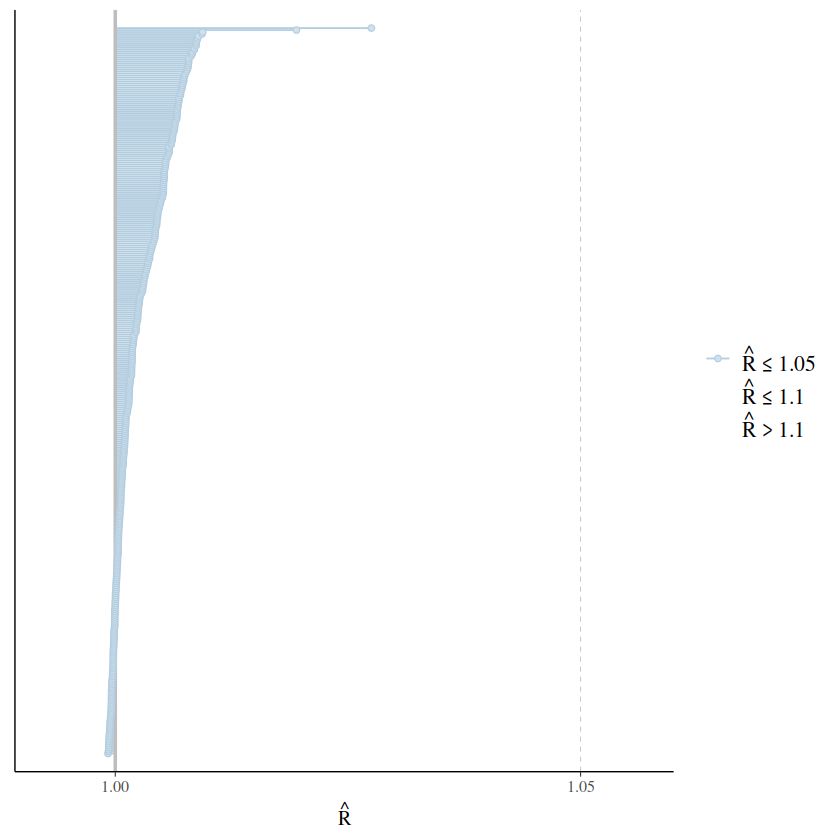

Inference for Stan model: anon_model.
4 chains, each with iter=30000; warmup=10000; thin=20; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean    sd    2.5%     50%  97.5% n_eff Rhat
mu[1]       -0.43    0.04  1.98   -5.08   -0.21   2.87  2280 1.00
mu[2]       -0.18    0.04  1.92   -4.60   -0.02   3.27  2607 1.00
mu[3]        0.07    0.03  1.89   -4.15    0.15   3.64  3372 1.00
mu[4]        0.32    0.03  1.85   -3.50    0.36   3.80  3510 1.00
mu[5]        0.56    0.03  1.81   -3.09    0.55   4.14  3857 1.00
mu[6]        0.80    0.03  1.75   -2.67    0.74   4.52  3965 1.00
mu[7]        1.04    0.03  1.64   -1.96    0.92   4.64  2554 1.00
mu[8]        1.29    0.04  1.52   -1.23    1.11   4.71  1435 1.01
mu[9]        1.38    0.04  1.54   -1.17    1.20   4.97  1840 1.00
mu[10]       1.47    0.04  1.48   -0.98    1.31   4.77  1391 1.00
mu[11]       1.56    0.04  1.40   -0.71    1.37   4.85  1176 1.00
mu[12]       1.51    0.04  1.35   -0.72    1.36  

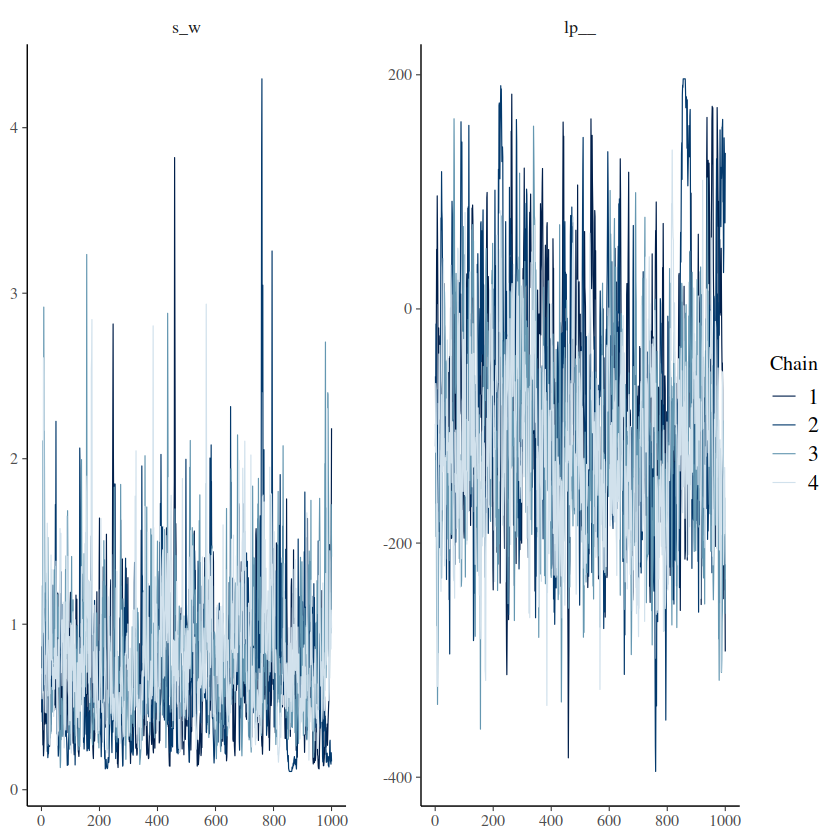

In [6]:
mcmc_rhat(rhat(dlgm_binom))
check_hmc_diagnostics(dlgm_binom)

mcmc_sample <- rstan::extract(dlgm_binom, permuted = FALSE)
mcmc_trace(mcmc_sample, pars = c("s_w", "lp__"))

options(max.print = 100000)
print(dlgm_binom, probs = c(0.025, 0.5, 0.975))


In [7]:
print(
  dlgm_binom,
  par = c("s_w", "lp__"),
  probs = c(0.025, 0.5, 0.975)
)


Inference for Stan model: anon_model.
4 chains, each with iter=30000; warmup=10000; thin=20; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean    sd    2.5%     50%  97.5% n_eff Rhat
s_w    0.75    0.02  0.41    0.19    0.69   1.71   375 1.02
lp__ -96.59    5.73 91.05 -250.68 -106.07 109.90   253 1.03

Samples were drawn using NUTS(diag_e) at Tue Sep 17 08:06:37 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
years <- seq(
  from = as.POSIXct("1829-01-01"),
  by = "1 year",
  len = length(boat)
)

head(years, n = 3)


[1] "1829-01-01 LMT" "1830-01-01 LMT" "1831-01-01 LMT"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 28 rows containing missing values or values outside the scale range
(`geom_point()`).”


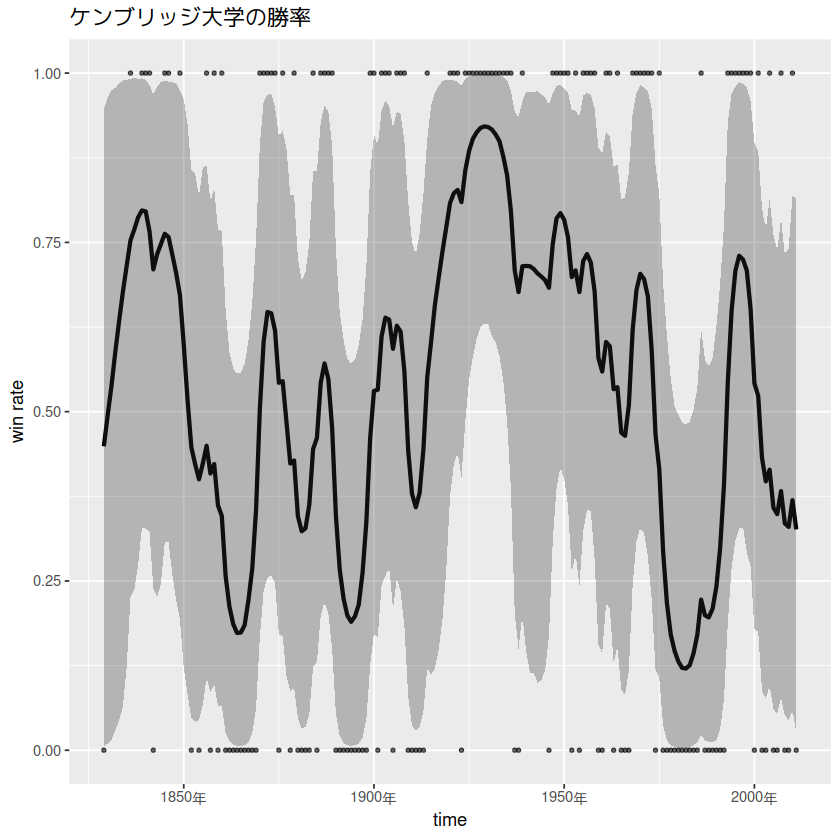

In [11]:
rstan::extract(dlgm_binom) %>%
  plotSSM(
    time_vec = years,
    obs_vec = as.numeric(boat),
    state_name = "probs",
    graph_title = "ケンブリッジ大学の勝率",
    y_label = "win rate",
    date_labels = "%Y年"
  )
